In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import itertools
import seaborn as sns
sns.set(color_codes=True)
#sns.set_context('poster')
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

import sklearn as sk
import sklearn.cluster as cluster
from sklearn import linear_model, decomposition
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import time
np.set_printoptions(precision=6)

In [2]:
# load cleaned data
dtypespec = {"weeks": object, "peak": object, "var9": object, "var10": object, "var11": object, "var12": object, "var13": object}
billboardDF = pd.read_csv('billboardDF.csv',sep=",",header='infer', dtype=dtypespec)
evolutionDF = pd.read_csv('evolutionDF.csv',sep=",",header='infer')
uniqueTracksDF = pd.read_csv('evolutionDF.csv',sep=",",header='infer')
musicDF = pd.read_csv('musicDF.csv',sep=",",header='infer')
musicSubset = pd.read_csv('musicSubset.csv',sep=",",header='infer')
clusterDF = musicSubset.ix[:, 12:28].copy()

In [3]:
## MULTINOMIAL LOGISTIC REGRESSION - testing out different variable combinations
X = clusterDF
Y = musicSubset['decade']
c = 1e5

logreg = linear_model.LogisticRegression(C=c, multi_class = 'ovr')
logreg.fit(X, Y)
print('one-vs-rest, liblinear')
print(logreg.score(X,Y))

logreg = linear_model.LogisticRegression(C=c, multi_class = 'ovr', solver='newton-cg')
logreg.fit(X, Y)
print('one-vs-rest, newton-cg')
print(logreg.score(X,Y))

logreg = linear_model.LogisticRegression(C=c, multi_class = 'multinomial', solver='newton-cg')
logreg.fit(X, Y)
print('multinomial, newton-cg')
print(logreg.score(X,Y))

logreg = linear_model.LogisticRegression(C=c, multi_class = 'multinomial', solver='lbfgs')
logreg.fit(X, Y)
print('multinomial, lbfgs')
print(logreg.score(X,Y))

one-vs-rest, liblinear
0.421024921025
one-vs-rest, newton-cg
0.420907920908
multinomial, newton-cg
0.424008424008
multinomial, lbfgs
0.42394992395


In [18]:
# USE PARTITIONED DATA
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.20, random_state=42)
fit_mn_logreg = linear_model.LogisticRegression(C=c, multi_class = 'multinomial', solver='newton-cg')
fit_mn_logreg.fit(Xtrain, Ytrain)
Yhat_mn = fit_mn_logreg.predict(Xtest)
print('multinomial, newton-cg')
print(fit_mn_logreg.score(Xtest,Ytest))

fit_ovr_logreg = linear_model.LogisticRegression(C=c, multi_class = 'ovr', solver='liblinear')
fit_ovr_logreg.fit(Xtrain, Ytrain)
Yhat_ovr = fit_ovr_logreg.predict(Xtest)
print('ovr, liblinear')
print(fit_ovr_logreg.score(Xtest,Ytest))

multinomial, newton-cg
0.426440479672
ovr, liblinear
0.42614799649


In [19]:
print(type(Yhat_mn))
multinomial_conmat = sk.metrics.confusion_matrix(Ytest, Yhat_mn)
print(multinomial_conmat)
print('\r\n')
ovr_conmat = sk.metrics.confusion_matrix(Ytest, Yhat_ovr)
print(ovr_conmat)

<class 'numpy.ndarray'>
[[732 122  99  15  69]
 [349 217  82  37  69]
 [146 124 206  43  38]
 [109  65 103 105 110]
 [154  93  95  39 198]]


[[760 101 101  14  61]
 [375 203  82  30  64]
 [156 126 200  38  37]
 [113  72 102  96 109]
 [163  93  93  32 198]]


In [6]:
def analyzeConfusionMatrix(conmat):
    # Accuracy per decade
    accuracies = []
    for i in range(0, len(set(Y))):
        accuracies.append(conmat[i,i]/np.sum(conmat[i,:]))
    print("accuracy per decade")
    print(np.transpose(accuracies))

    # Accuracy/20% per decade
    accuracies = []
    for i in range(0, len(set(Y))):
        accuracies.append(conmat[i,i]/np.sum(conmat[i,:])/.2)
    print("accuracy/20% per decade")
    print(np.transpose(accuracies))

    # Precision per decade
    accuracies = []
    for i in range(0, len(set(Y))):
        accuracies.append(conmat[i,i]/np.sum(conmat[:,i]))
    print("precision per decade")
    print(np.transpose(accuracies))

In [7]:
analyzeConfusionMatrix(multinomial_conmat)

accuracy per decade
[ 0.705882  0.287798  0.369838  0.213415  0.341969]
accuracy/20% per decade
[ 3.529412  1.438992  1.849192  1.067073  1.709845]
precision per decade
[ 0.491275  0.349436  0.352137  0.439331  0.409091]


In [8]:
analyzeConfusionMatrix(ovr_conmat)

accuracy per decade
[ 0.732883  0.269231  0.359066  0.195122  0.341969]
accuracy/20% per decade
[ 3.664417  1.346154  1.795332  0.97561   1.709845]
precision per decade
[ 0.485003  0.341176  0.346021  0.457143  0.422175]


In [15]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize==True:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    cm = np.round(cm, 2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [10]:
sum(multinomial_conmat.diagonal())/len(Yhat_mn)

0.42644047967241883

Confusion matrix, without normalization
[[732 122  99  15  69]
 [349 217  82  37  69]
 [146 124 206  43  38]
 [109  65 103 105 110]
 [154  93  95  39 198]]


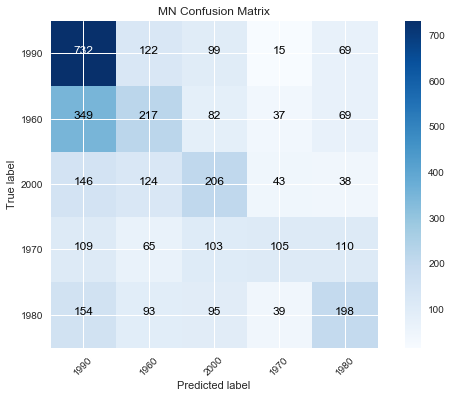

Normalized confusion matrix
[[ 0.705882  0.117647  0.095468  0.014465  0.066538]
 [ 0.462865  0.287798  0.108753  0.049072  0.091512]
 [ 0.262118  0.222621  0.369838  0.077199  0.068223]
 [ 0.221545  0.132114  0.20935   0.213415  0.223577]
 [ 0.265976  0.160622  0.164076  0.067358  0.341969]]


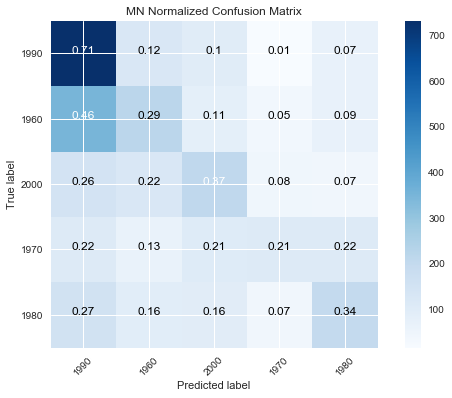

accuracy =  0.426440479672 

Confusion matrix, without normalization
[[760 101 101  14  61]
 [375 203  82  30  64]
 [156 126 200  38  37]
 [113  72 102  96 109]
 [163  93  93  32 198]]


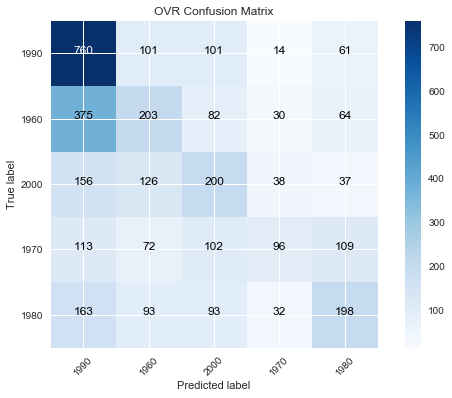

accuracy =  0.42614799649 



In [17]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(multinomial_conmat, classes=set(Yhat_mn), normalize=False,
                      title='MN Confusion Matrix')

plt.show()
plt.figure()
plot_confusion_matrix(multinomial_conmat, classes=set(Yhat_mn), normalize=True,
                      title='MN Normalized Confusion Matrix')

plt.show()
accuracy = sum(multinomial_conmat.diagonal())/len(Yhat_mn)
print("accuracy = ", accuracy, "\r\n")

plt.figure()
plot_confusion_matrix(ovr_conmat, classes=set(Yhat_mn), normalize=False,
                      title='OVR Confusion Matrix')

plt.show()
accuracy = sum(ovr_conmat.diagonal())/len(Yhat_mn)
print("accuracy = ", accuracy, "\r\n")

In [12]:
classifier = sk.svm.SVC(kernel='linear', C=0.01)
yPred = classifier.fit(Xtrain, Ytrain).predict(Xtest)

Confusion matrix, without normalization
[[979  12  32   1  13]
 [661  50  24   0  19]
 [423  39  72   1  22]
 [281  30  48  10 123]
 [396  21  30   2 130]]


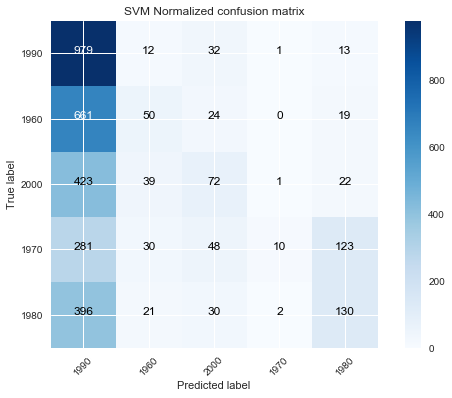

In [66]:
svm_conmat = confusion_matrix(Ytest, yPred)
plt.figure()
plot_confusion_matrix(svm_conmat, classes=set(Yhat_mn), normalize=False,
                      title='SVM Normalized confusion matrix')

plt.show()

In [50]:
classifier = sk.svm.SVC(kernel='linear', C=0.01)
yPred = classifier.fit(Xtrain, Ytrain).predict(Xtest)

Confusion matrix, without normalization
[[979  12  32   1  13]
 [661  50  24   0  19]
 [423  39  72   1  22]
 [281  30  48  10 123]
 [396  21  30   2 130]]


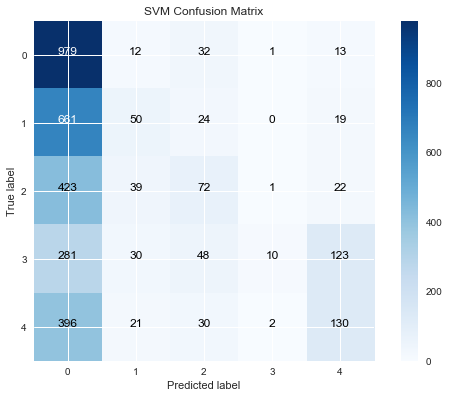

Normalized confusion matrix
[[ 0.944069  0.011572  0.030858  0.000964  0.012536]
 [ 0.876658  0.066313  0.03183   0.        0.025199]
 [ 0.759425  0.070018  0.129264  0.001795  0.039497]
 [ 0.571138  0.060976  0.097561  0.020325  0.25    ]
 [ 0.683938  0.036269  0.051813  0.003454  0.224525]]


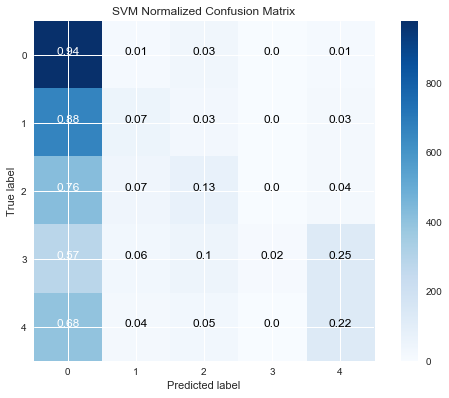

In [53]:
svm_conmat = confusion_matrix(Ytest, yPred)
plt.figure()
plot_confusion_matrix(svm_conmat, classes=set(Yhat_mn), normalize=False,
                      title='SVM Confusion Matrix')

plt.show()
plt.figure()
plot_confusion_matrix(svm_conmat, classes=set(Yhat_mn), normalize=True,
                      title='SVM Normalized Confusion Matrix')

plt.show()

In [14]:
type(multinomial_conmat)
type(Yhat_mn)

numpy.ndarray